In [1]:
%matplotlib inline
%load_ext line_profiler


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.stats
import uncertainties.unumpy as unp
from uncertainties import ufloat

In [3]:
from effort2.rates.BtoV import BtoV
from effort2.formfactors.formFactorBtoC import BToDStarCLN, BToDStarBGL

In [4]:
bToDStarCLN = BToDStarCLN(
    m_B=5.27963, 
    m_M=2.01026, 
    h_A1_1=0.906,
    rho2=1.03, 
    R1_1=1.38, 
    R2_1=0.97
)

In [5]:
# Florian
#vcb = 41.6558e-3
vcb = 40e-3
eta_ew = 1.0066
a = np.array([3.79139e-04, 2.69537e-02]) / vcb / eta_ew
b = np.array([5.49846e-04, -2.04028e-03]) / vcb / eta_ew
c = np.array([-4.32818e-04, 5.35029e-03]) / vcb / eta_ew
del vcb
del eta_ew

# # Grinstein
# vcb = 41.9e-3
# eta_ew = 1.0066
# a = np.array([-0.039e-2, -2.77e-2]) / vcb / eta_ew
# b = np.array([0.056e-2, -0.22e-2]) / vcb / eta_ew
# c = np.array([-0.046e-2, 0.59e-2]) / vcb / eta_ew
# del vcb
# del eta_ew

bToDStarBGL = BToDStarBGL(
    m_B=5.27963,
    m_M=2.01026,
    exp_coeff_a = a,
    exp_coeff_b = b,
    exp_coeff_c = c,
)

In [6]:
rate_cln = BtoV(bToDStarCLN, 40e-3, bToDStarCLN.m_B, bToDStarCLN.m_M) 
rate_bgl = BtoV(bToDStarBGL, 40e-3, bToDStarBGL.m_B, bToDStarBGL.m_M) 

In [7]:
rate = rate_bgl
del rate_cln
del rate_bgl

In [8]:
wbins = np.linspace(rate.w_min, rate.w_max, num=11)
cosLbins = np.linspace(rate.cosL_min, rate.cosL_max, num=11)
cosVbins = np.linspace(rate.cosV_min, rate.cosV_max, num=11)
chibins = np.linspace(rate.chi_min, rate.chi_max, num=11)


In [13]:
scipy.integrate.nquad(
    lambda x,y: rate.dGamma_dcosV_dchi(x, y) / rate.Gamma(),
    (
        (rate.cosV_min, rate.cosV_max),
        (rate.chi_min, rate.chi_max)
    )
)

(625.0, 6.910395433624744e-08)

In [9]:
N = int(1e6)

In [10]:
%%time
mc = pd.DataFrame(data=rate.generate_events(N), columns=["w", "cosL", "cosV", "chi", "rate"])

mc["w_bin"] = pd.cut(mc.w, wbins, labels=False)
mc["cosL_bin"] = pd.cut(mc.cosL, cosLbins, labels=False)
mc["cosV_bin"] = pd.cut(mc.cosV, cosVbins, labels=False)
mc["chi_bin"] = pd.cut(mc.chi, chibins, labels=False)

mc.to_pickle("toy_mc.pkl")

CPU times: user 19min 22s, sys: 1.67 s, total: 19min 24s
Wall time: 19min 24s


Calculate absolute number of expected events in our toy data sample.

/home/mapr/projects/eFFORT2/effort2/formfactors/formFactorBtoC.py:239: RuntimeWarning: divide by zero encountered in double_scalars
  return (w - self.r) / (w - 1) - self.F1(z) / self.m_B / (w - 1) / self.f(z)
/home/mapr/projects/eFFORT2/effort2/formfactors/formFactorBtoC.py:239: RuntimeWarning: invalid value encountered in double_scalars
  return (w - self.r) / (w - 1) - self.F1(z) / self.m_B / (w - 1) / self.f(z)
/home/mapr/projects/eFFORT2/effort2/formfactors/formFactorBtoC.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / (2 * m_M * q2 ** 0.5) * ((m_B ** 2 - m_M ** 2 - q2) * (m_B + m_M) * self.A1(w)


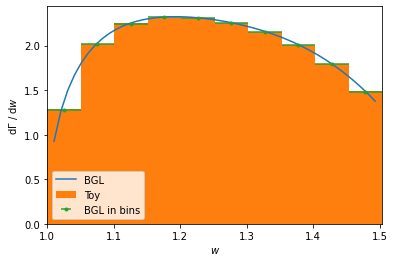

In [11]:
w = np.linspace(rate.w_min, rate.w_max)
wbins = np.linspace(rate.w_min, rate.w_max, num=11)

plt.plot(w, [rate.dGamma_dw(x) / rate.Gamma() for x in w], label="BGL")
plt.hist(mc.w, density=True, label="Toy")
plt.errorbar(wbins[:-1] + (wbins[1] - wbins[0]) / 2, [rate.DGamma_Dw(l, u)/ (u-l) / rate.Gamma() for (l, u) in zip(wbins, wbins[1:])], marker='.', xerr=(wbins[1] - wbins[0]) / 2, ls='', label="BGL in bins")
plt.xlim(min(w), max(w))
#plt.ylim(0, 7e-14)
plt.xlabel("$w$")
plt.ylabel("d$\Gamma$ / d$w$")
plt.legend()
plt.show()
plt.close()

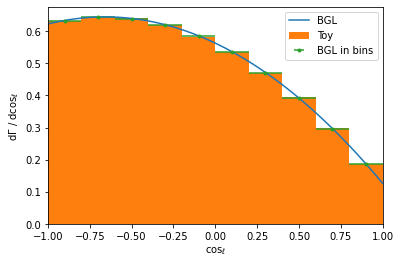

In [12]:
cosL = np.linspace(rate.cosL_min, rate.cosL_max)
cosLbins = np.linspace(rate.cosL_min, rate.cosL_max, num=11)

plt.plot(cosL, [rate.dGamma_dcosL(x) / rate.Gamma() for x in cosL], label="BGL")
plt.hist(mc.cosL, density=True, label="Toy")
plt.errorbar(cosLbins[:-1] + (cosLbins[1] - cosLbins[0]) / 2, [rate.DGamma_DcosL(l, u)/ (u-l) / rate.Gamma() for (l, u) in zip(cosLbins, cosLbins[1:])], marker='.', xerr=(cosLbins[1] - cosLbins[0]) / 2, ls='', label="BGL in bins")
plt.xlim(min(cosL), max(cosL))
#plt.ylim(0, 4e-14)
plt.xlabel("$\cos_\ell$")
plt.ylabel("d$\Gamma$ / d$\cos_\ell$")
plt.legend()
plt.show()
plt.close()

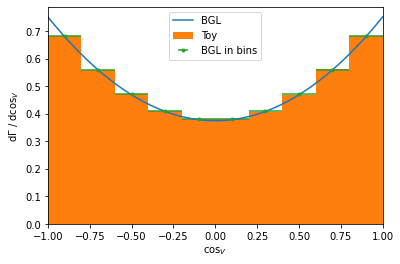

In [13]:
cosV = np.linspace(rate.cosV_min, rate.cosV_max)
cosVbins = np.linspace(rate.cosV_min, rate.cosV_max, num=11)

plt.plot(cosV, [rate.dGamma_dcosV(x) / rate.Gamma() for x in cosV], label="BGL")
plt.hist(mc.cosV, density=True, label="Toy")
plt.errorbar(cosVbins[:-1] + (cosVbins[1] - cosVbins[0]) / 2, [rate.DGamma_DcosV(l, u)/ (u-l) / rate.Gamma() for (l, u) in zip(cosVbins, cosVbins[1:])], marker='.', xerr=(cosVbins[1] - cosVbins[0]) / 2, ls='', label="BGL in bins")
plt.xlim(min(cosV), max(cosV))
#plt.ylim(0, 4e-14)
plt.xlabel("$\cos_V$")
plt.ylabel("d$\Gamma$ / d$\cos_V$")
plt.legend()
plt.show()
plt.close()

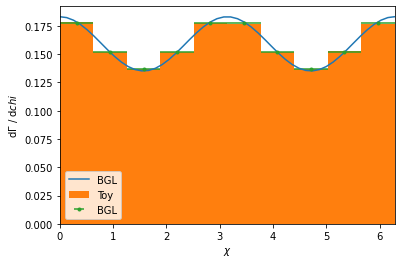

In [14]:
chi = np.linspace(rate.chi_min, rate.chi_max)
chibins = np.linspace(rate.chi_min, rate.chi_max, num=11)

plt.plot(chi, [rate.dGamma_dchi(x) / rate.Gamma() for x in chi], label="BGL")
plt.hist(mc.chi, density=True, label="Toy")
plt.errorbar(chibins[:-1] + (chibins[1] - chibins[0]) / 2, [rate.DGamma_Dchi(l, u)/ (u-l) / rate.Gamma() for (l, u) in zip(chibins, chibins[1:])], marker='.', xerr=(chibins[1] - chibins[0]) / 2, ls='', label="BGL")
plt.xlim(min(chi), max(chi))
#plt.ylim(0, 1e-14)
plt.xlabel("$\chi$")
plt.ylabel("d$\Gamma$ / d$chi$")
plt.legend()
plt.show()
plt.close()